In [191]:
import os, tempfile
from pylab import *
import numpy as np
from CSXCAD  import CSXCAD
from openEMS import openEMS
from openEMS.physical_constants import *
from scipy.interpolate import *

import matplotlib.pylab as plt
%matplotlib inline

In [192]:
# Definizione dei campi per una guida circolare.

def GetCircField(CSXmesh, prio, portnr, start, stop, radius, mode_name, pol_ang=0, exc_amp=0, cyl_system=True):
    if (mode_name[0:2] != 'TE'):
        raise Exception("Only TE modes are supported.")
    
    pnm = 0
    
    n = int(mode_name[2])
    m = int(mode_name[3])
    
    # Values by David M. Pozar, Microwave Engineering, third edition
    if ((n==0) and (m==1)):
        pnm = 3.832
    elif ((n==1) and (m==1)):
        pnm = 1.841;
    elif ((n==2) and (m==1)):
        pnm = 3.054;
    elif ((n==0) and (m==2)):
        pnm = 7.016;
    elif ((n==1) and (m==2)):
        pnm = 5.331
    elif ((n==2) and (m==2)):
        pnm = 6.706
    elif ((n==0) and (m==3)):
        pnm = 10.174
    elif ((n==1) and (m==3)):
        pnm = 8.536
    elif ((n==2) and (m==3)):
        pnm = 9.970
        print("TE23")
    else:
        raise Exception('Invalid TE_nm mode')
        
    unit = CSXmesh.GetDeltaUnit()
    kc = pnm/radius
    kc_draw = kc*unit
    
    angle = "a-"+("%9.8f" % pol_ang)
    
    # Functions by David M. Pozar, Microwave Engineering, third edition
    
    # Electric field mode profile
    func_Er = ("%9.8f" % (-1/(kc_draw**2))) + '/rho*cos('+angle+')*j1(' +("%9.8f" % kc_draw) +'*rho)'
    func_Ea = ("%9.8f" % (1/kc_draw)) + '*sin(' + angle + ')*0.5*(j0(' + ("%9.8f" % kc_draw) + '*rho)-jn(2,' +  ("%9.8f" % kc_draw) + '*rho))'
    
    # Magnetic field mode profile
    func_Hr = ("%9.8f" % (-1/kc_draw)) + '*sin(' + angle + ')*0.5*(j0(' + ("%9.8f" % kc_draw) + '*rho)-jn(2,' +  ("%9.8f" % kc_draw) + '*rho))'
    func_Ha = ("%9.8f" % (-1/(kc_draw**2))) + '/rho*cos(' + angle + ')*j1(' + ("%9.8f" % kc_draw) + '*rho)'
    
    if (cyl_system):
        func_E = [func_Er, func_Ea, 0];
        func_H = [func_Hr, func_Ha, 0];
    else:
        func_Ex = '(' + func_Er + '*cos(a) - ' + func_Ea + '*sin(a) ) * (rho<' + ("%9.8f" % (radius/unit)) + ')'
        func_Ey = '(' + func_Er + '*sin(a) + ' + func_Ea + '*cos(a) ) * (rho<' + ("%9.8f" % (radius/unit)) + ')'
        func_E = [func_Ex, func_Ey, 0];
    
        func_Hx = '(' + func_Hr + '*cos(a) - ' + func_Ha + '*sin(a) ) * (rho<' + ("%9.8f" % (radius/unit)) + ')'
        func_Hy = '(' + func_Hr + '*sin(a) + ' + func_Ha + '*cos(a) ) * (rho<' + ("%9.8f" % (radius/unit)) + ')'
        func_H = [func_Hx, func_Hy, 0];
        
        
    # return FDTD.AddWaveGuidePort(portnr, start, stop, 'z', func_E, func_H, kc, exc_amp)
    return func_E, func_H, kc


In [193]:
Sim_Path = os.path.join('/home/algebrato', 'Horn_COSMO')
post_proc_only=False

In [194]:
Sim_Path

'/home/algebrato/Horn_COSMO'

In [195]:
# All lengths are in mm

unit = 1e-3

horn_length = 25*0.66

horn_radius = 2
horn_thickness = 0.5*0.66
horn_feed_length = 5*0.66

L=70.0;
x_dot = np.array([2/0.66, 4.35, 5.17, 5.53, 6.82, 9.10, 11.04])*0.66;
z_dot = np.array([0.0, 0.17, 0.34, 0.51, 0.68, 0.85, 1.0])*L*0.66;

Cub_spl_fun = CubicSpline(z_dot, x_dot)


In [196]:
SimBox = np.array([15, 15, 40])*2*0.66

# frequency range of interest
f_start =  80e9/0.66;
f_stop  =  116e9/0.66;

# Frequency of interest
f0 = 100e9/0.66;

In [197]:
FDTD = openEMS(NrTS=30000, EndCriteria=1e-3)
FDTD.SetGaussExcite(0.5*(f_start+f_stop), 0.5*(f_stop-f_start))
FDTD.SetBoundaryCond(['PML_8', 'PML_8', 'PML_8', 'PML_8', 'PML_8', 'PML_8'])

In [198]:
CSX = CSXCAD.ContinuousStructure()
FDTD.SetCSX(CSX)
mesh = CSX.GetGrid()
mesh.SetDeltaUnit(1e-3)
mesh_res = C0 / (f_stop) / unit / 15;

In [199]:
mesh.AddLine('x', [-SimBox[0]/2, -horn_radius, 0, horn_radius, SimBox[0]/2])
mesh.SmoothMeshLines('x', mesh_res, 1.4)

mesh.AddLine('y', [-SimBox[0]/2, -horn_radius, 0, horn_radius, SimBox[0]/2])
mesh.SmoothMeshLines('y', mesh_res, 1.4)

mesh.AddLine('z', [-horn_feed_length, 0, SimBox[2]])
mesh.SmoothMeshLines('z', mesh_res, 1.4)

In [200]:
conical_horn = CSX.AddMetal("Horn_COSMO")

In [201]:
samples = np.linspace(0, L*0.66, 100);
samples_inv = np.linspace(L*0.66, 0, 100);

spline_x = Cub_spl_fun(samples)
spline_x_inv = Cub_spl_fun(samples_inv)

top = spline_x[-1]

xhorn = r_[horn_radius, horn_radius, spline_x, top+horn_thickness, spline_x_inv+horn_thickness, horn_radius+horn_thickness]
zhorn = r_[-horn_feed_length, 0, samples, L*0.66, samples_inv, -horn_feed_length];

conical_horn.AddRotPoly(np.array([xhorn, zhorn]), 'x', 0, 'z', np.array([0, 2*np.pi]))

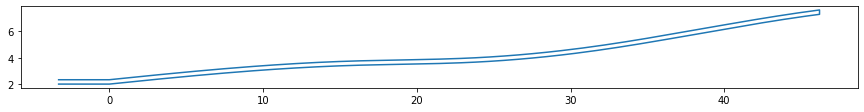

In [202]:
plt.figure(figsize=(15, 1.5))
plt.plot(zhorn, xhorn)


In [203]:
# %% apply the excitation %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# start=[-horn.radius -horn.radius mesh.z(10) ];
# stop =[+horn.radius +horn.radius mesh.z(1)+horn.feed_length/2 ];
# [CSX, port] = AddCircWaveGuidePort( CSX, 0, 1, start, stop, horn.radius*unit, 'TE11', 0, 1);
start = [-horn_radius, -horn_radius, mesh.GetLines('z')[9]]
stop = [horn_radius, +horn_radius, mesh.GetLines('z')[0]+(horn_feed_length/2)]

E, H, kc = GetCircField(mesh, 1, 0, start, stop, horn_radius*unit, "TE11", 0, 1, False)

In [204]:
port = FDTD.AddWaveGuidePort(0, start, stop, 'z', E, H, kc, 1)
# port = AddCircWaveGuidePort(mesh, 1, 0, start, stop, horn_radius*unit, 'TE11', 0, 1)
# port = FDTD.AddRectWaveGuidePort(0, start, stop, 'z', a*1e-3, b*1e-3, 'TE11', 1)


In [205]:
Et = CSX.AddDump('Exc_dump')#, file_type=0, sub_sampling=[2, 2, 2])
start_dump = [-horn_radius, -horn_radius, mesh.GetLines('z')[7]]
stop_dump  = [+horn_radius, +horn_radius, mesh.GetLines('z')[7]]
Et.AddBox(start_dump, stop_dump)

In [206]:
if 1:  # debugging only
    CSX_file = os.path.join(Sim_Path, 'Con_Feed.xml')
    if not os.path.exists(Sim_Path):
        os.mkdir(Sim_Path)
    CSX.Write2XML(CSX_file)
    #os.system(r'AppCSXCAD "{}"'.format(CSX_file))

In [183]:
start_nf = [mesh.GetLines('x')[8], mesh.GetLines('y')[8], mesh.GetLines('z')[8]]
stop_nf  = [mesh.GetLines('x')[-7], mesh.GetLines('y')[-7], mesh.GetLines('z')[-7]]
nf2ff = FDTD.CreateNF2FFBox(name='nf2ff', start=start_nf, stop=stop_nf)

In [184]:
FDTD.Run(Sim_Path, verbose=3, cleanup=True)

In [186]:
theta = np.arange(-90.0, 90.0, 1.0)
phi   = [0, 45, 90]
nf2ff_res = nf2ff.CalcNF2FF(Sim_Path, 100e9/0.66, theta, phi, center=[0,0,1e-3])

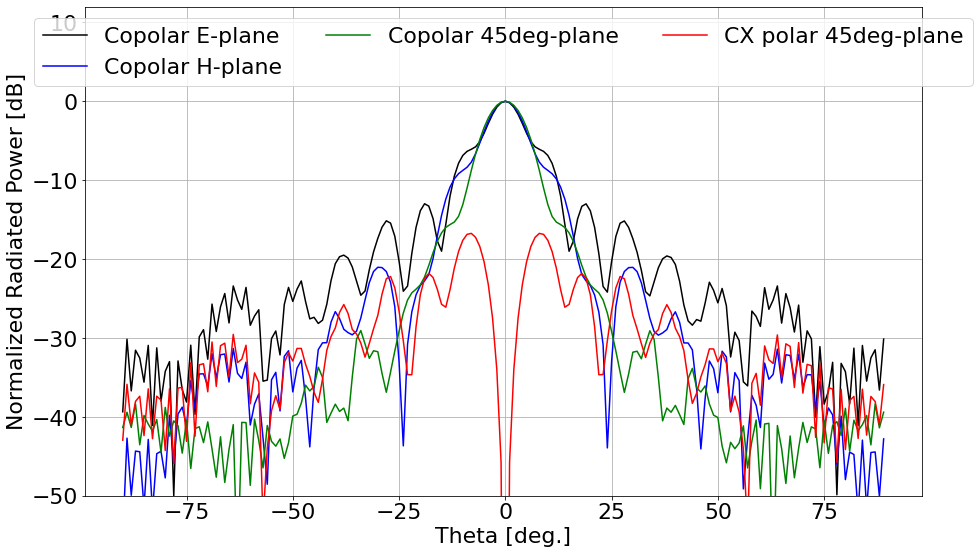

In [187]:
plt.rcParams.update({'font.size': 22})

E_theta = nf2ff_res.E_theta[0] / np.amax(nf2ff_res.E_norm[0])
E_phi   = nf2ff_res.E_phi[0] / np.amax(nf2ff_res.E_norm[0])

E_co    = E_theta * np.cos(nf2ff_res.phi) - E_phi * np.sin(nf2ff_res.phi)
E_cx    = E_theta * np.sin(nf2ff_res.phi) + E_phi * np.cos(nf2ff_res.phi)

E_co_log = 20*np.log10(np.abs(E_co)) + 10 * np.log10(nf2ff_res.Dmax[0])
E_cx_log = 20*np.log10(np.abs(E_cx)) + 10 * np.log10(nf2ff_res.Dmax[0])

plt.figure(figsize=(15,9))
plt.plot(nf2ff_res.theta*180/np.pi, (E_co_log[:,0]) - 10*np.log10(nf2ff_res.Dmax)[0], 'k-', label='Copolar E-plane')
plt.plot(nf2ff_res.theta*180/np.pi, E_co_log[:,1] - 10*np.log10(nf2ff_res.Dmax)[0], 'b-', label='Copolar H-plane')
plt.plot(nf2ff_res.theta*180/np.pi, E_co_log[:,2] - 10*np.log10(nf2ff_res.Dmax)[0], 'g-', label='Copolar 45deg-plane')
plt.plot(nf2ff_res.theta*180/np.pi, E_cx_log[:,1] - 10*np.log10(nf2ff_res.Dmax)[0], 'r-', label='CX polar 45deg-plane')
plt.xlabel("Theta [deg.]")
plt.ylabel("Normalized Radiated Power [dB]")
plt.ylim((-50, 12))
#plt.xlim((-30, 30))
plt.grid()
plt.legend(loc='upper center', ncol=3)#, bbox_to_anchor=(0.5, -0.05),&nbsp; shadow=True, ncol=2)
plt.savefig("TE11_rad_path.pdf")


In [188]:
port.CalcPort(Sim_Path, np.linspace(f_start, f_stop, 201))

port_ut_0
port_it_0


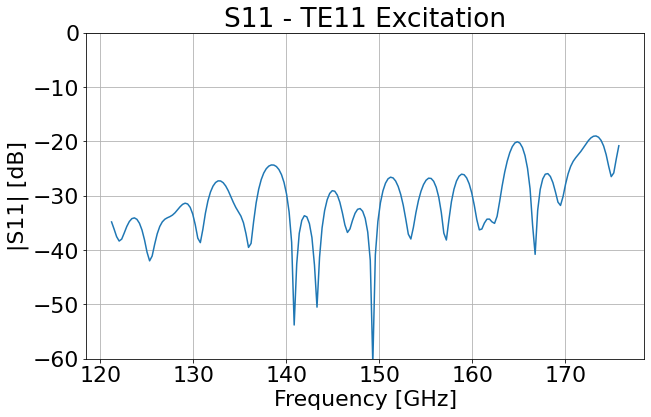

In [189]:
plt.figure(figsize=(10,6))
plt.title("S11 - TE11 Excitation")
plot(np.linspace(f_start, f_stop, 201)/1e9, 20*np.log10(np.abs(port.uf_ref / port.uf_inc)))
plt.ylabel("|S11| [dB]")
plt.xlabel("Frequency [GHz]")
plt.ylim((-60, 0))
plt.grid()
plt.savefig("TE12_S11.pdf")

In [190]:
print("Radiated power: Prad = {0} watt".format(nf2ff_res.Prad[0]))
print("Directivity:    Dmax = {0} dBi".format(10*np.log10(nf2ff_res.Dmax)[0]))

Radiated power: Prad = 3.455716122697991e-30 watt
Directivity:    Dmax = 20.31931320214808 dBi


In [116]:
np.save("E_theta_21", E_theta)
np.save("E_phi_21", E_phi)
np.save("S11_21", 20*np.log10(np.abs(port.uf_ref / port.uf_inc)))

<ipython-input-116-170b6574bd10>:3: RuntimeWarning: invalid value encountered in true_divide
  np.save("S11_21", 20*np.log10(np.abs(port.uf_ref / port.uf_inc)))


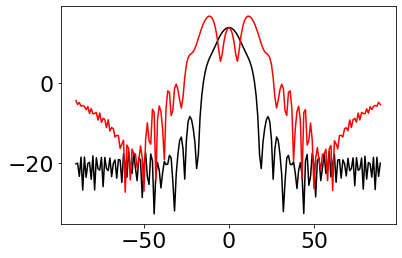

In [117]:
D_log = 20*log10(nf2ff_res.E_norm[0]/np.max(np.max(nf2ff_res.E_norm[0])))
D_log = D_log + 10*np.log10(nf2ff_res.Dmax);
plt.plot(nf2ff_res.theta*180/np.pi, D_log[:,0] ,'k-')
plt.plot(nf2ff_res.theta*180/np.pi, D_log[:,2] ,'r-')

#plt.ylim((-50, 30))
#plt.xlim((-30,30))